# X Account Data
### for @bodhichristian

This notebook is an exploration of X user and post data using pandas, numpy, and matplotlib to gain useful insights.

CSVs in current directory:  
- <b>account_overview_year.csv</b> - 365 days of account-related data such as Likes, New follows, and Profile visits  
- <b>account_content_quarter.csv</b> - 3 months of post-related data such as Post Id, Post text, and Engagements  

In [40]:
## Imports

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [41]:
## Create dataframes
overview = pd.read_csv('account_overview_year.csv')
posts = pd.read_csv('posts_3M.csv')

### Clean dates

In [42]:
# %a - abbreviated weekday name ('Mon')
# %b - abbreviated month name ('Feb')
# %d - day of the month ('25')
# %Y - four digit year (2025)

overview['Date'] = pd.to_datetime(overview['Date'], format='%a, %b %d, %Y')
posts['Date'] = pd.to_datetime(posts['Date'], format='%a %b %d %Y')

overview['Month'] = pd.Categorical(
    overview['Date'].dt.strftime('%b'),
    categories=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
    ordered=True
)

overview['Week number'] = (overview['Date'] - overview['Date'].min()).dt.days // 7 + 1

# order overview chronologically
overview = overview[::-1]

posts['Weekday'] = pd.Categorical(
    posts['Date'].dt.strftime('%a'),
    categories=['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'],
    ordered=True
)

# Account Overview (365 Days)

In [43]:
overview.head(2)

,Date,Impressions,Likes,Engagements,Bookmarks,Shares,New follows,Unfollows,Replies,Reposts,Profile visits,Create Post,Video views,Media views,Month,Week number
364,2024-02-26,2097,28,85,4,0,3,1,3,0,6,2,0,0,Feb,1
363,2024-02-27,2466,20,96,4,0,4,2,5,0,16,1,0,0,Feb,1


# Posts (3 Months)

In [44]:
posts.head(2)

,Post id,Date,Post text,Link,Impressions,Likes,Engagements,Bookmarks,Share,New follows,Replies,Reposts,Profile visits,Detail expands,Url clicks,Hashtag clicks,Permalink clicks,Weekday
0,1894144221424026012,2025-02-24,@KevinNaughtonJr it’s an acronym?,https://x.com/bodhichristian/status/1894144221...,409,0,2,0,0,0,0,0,1,1,0,0,0,Mon
1,1894097177032458244,2025-02-24,@OrdinaryInds https://t.co/10czV0rjBF,https://x.com/bodhichristian/status/1894097177...,11,1,1,0,0,0,0,0,0,0,0,0,0,Mon


## Engagement

In [45]:
total_impressions = overview['Impressions'].sum()
total_engagements = overview['Engagements'].sum()

engagement_rate = round((total_engagements / total_impressions * 100), 1)
print(f'Impressions: {total_impressions}')
print(f'Engagements: {total_engagements}')
print(f'Engagement rate: {engagement_rate}%')

Impressions: 1263207
Engagements: 53857
Engagement rate: 4.3%


### Avg Daily Engagement

In [46]:
avg_daily_engagement = (overview['Engagements'] / overview['Impressions']).mean() * 100
print(f'Average daily engagment: {avg_daily_engagement.round(1)}')

Average daily engagment: 3.8


### Monthly Engagement

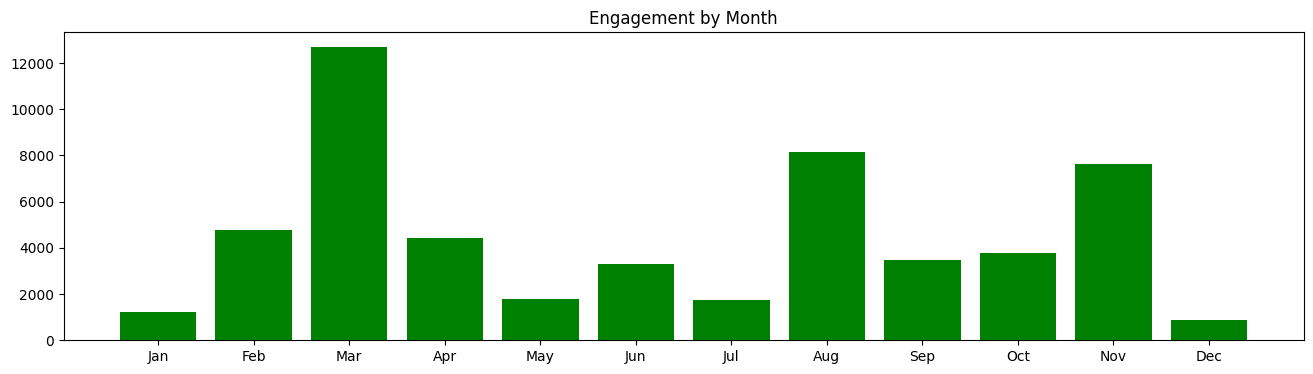

In [47]:
monthly_engagements = overview.groupby('Month', observed=True)['Engagements'].sum()

plt.figure(figsize=(16, 4))  
plt.title('Engagement by Month')
plt.bar(monthly_engagements.index, monthly_engagements.values, color='green')
plt.show()

### Monthly Impresssions

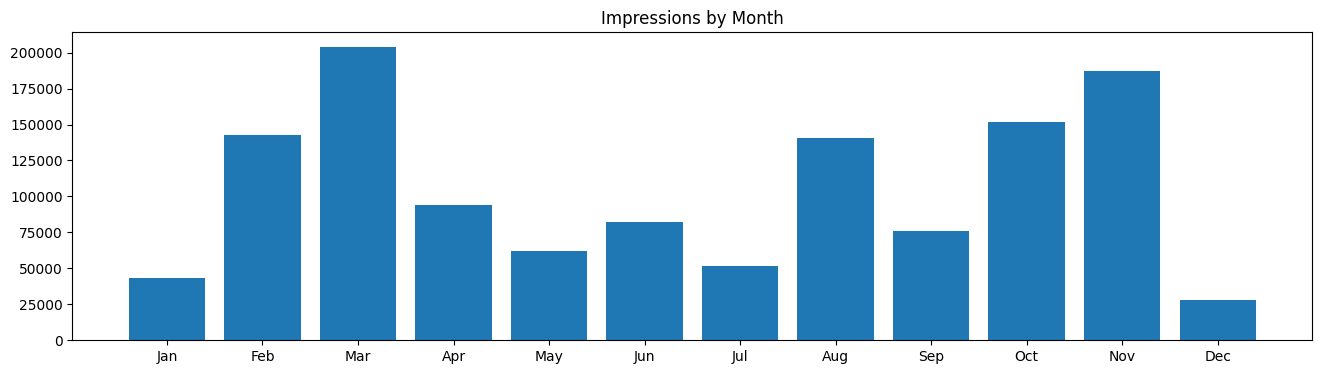

In [48]:
monthly_impressions = overview.groupby('Month', observed=True)['Impressions'].sum()

plt.figure(figsize=(16, 4))  
plt.title('Impressions by Month')
plt.bar(monthly_impressions.index, monthly_impressions.values)
plt.show()

### Posts vs Replies Receieved

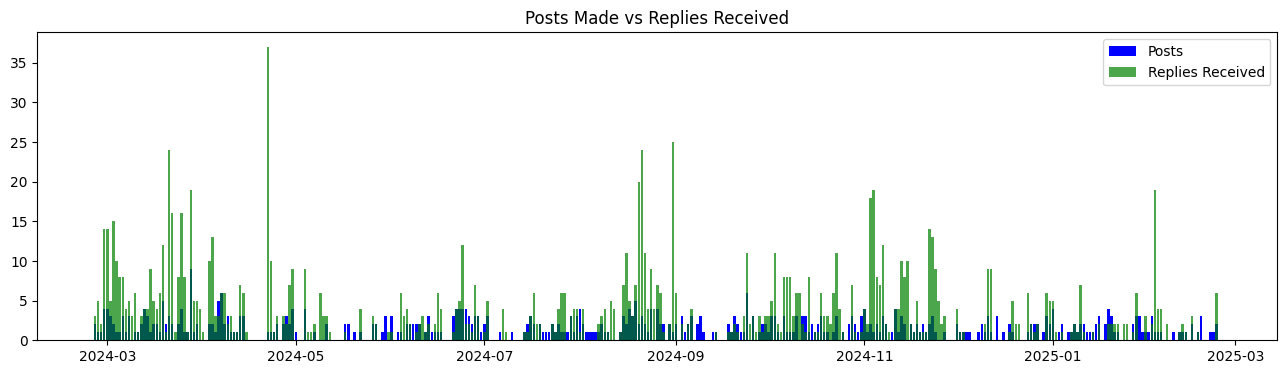

Average replies received per post: 2


In [49]:
x = overview['Date']
y_posts = overview['Create Post']
y_replies = overview['Replies']

plt.figure(figsize=(16,4))
plt.title('Posts Made vs Replies Received')
plt.bar(x, y_posts, color='blue', label='Posts')
plt.bar(x, y_replies, color='green', alpha=0.7, label='Replies Received')
plt.legend()
plt.show()

reply_rate = round(y_replies.sum() / y_posts.sum())
print(f'Average replies received per post: {reply_rate}')

### Profile Visist

In [50]:
profile_visits = overview['Profile visits'].sum()
print(f'Profile Visits: {profile_visits}')

Profile Visits: 6043


In [51]:
avg_daily_visits = round((profile_visits / 365), 1)
print(f'Average Daily Profile Vists: {avg_daily_visits}')

Average Daily Profile Vists: 16.6


### Post Data Overview

In [52]:
replies = overview['Replies'].sum()
likes = overview['Likes'].sum()
reposts = overview['Reposts'].sum()
bookmarks = overview['Bookmarks'].sum()
shares = overview['Shares'].sum()

print(f'Replies: {replies}')
print(f'Likes: {likes}')
print(f'Reposts: {reposts}')
print(f'Bookmarks: {bookmarks}')
print(f'Shares: {shares}')

Replies: 1210
Likes: 11656
Reposts: 397
Bookmarks: 4582
Shares: 156


### Net Daily Follower Change

In [53]:
net_follower_change = overview['New follows'] - overview['Unfollows']
print(f'Largest follower increase: {net_follower_change.max()}')
print(f'Largest follower decrease: {net_follower_change.min()}')
print(f'Average daily change: {net_follower_change.mean().round(2)}')

Largest follower increase: 94
Largest follower decrease: -5
Average daily change: 3.98


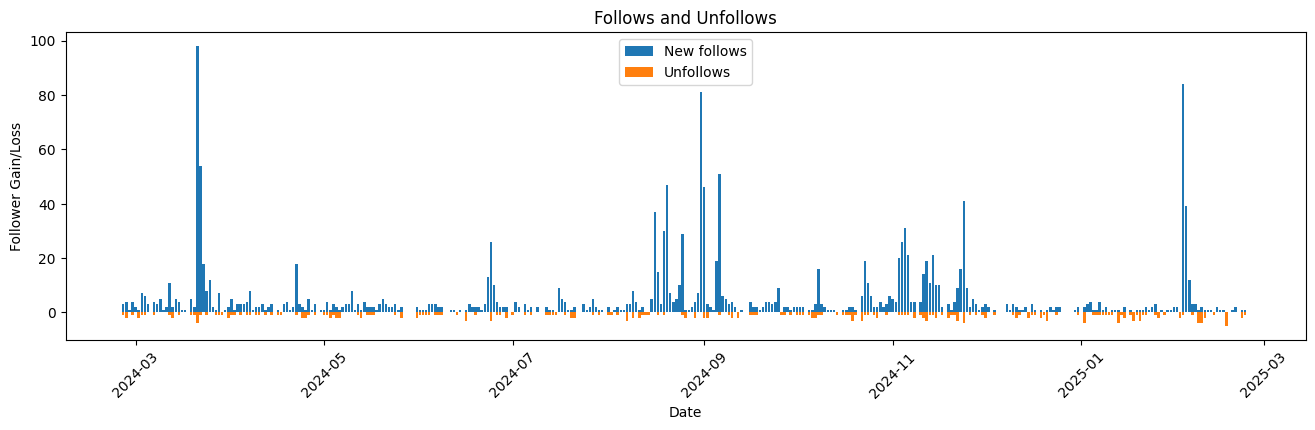

In [54]:
x = overview['Date']
y_follows = overview['New follows']
y_unfollows = (-overview['Unfollows'])

plt.figure(figsize=(16, 4))

plt.bar(x, y_follows, label='New follows')
plt.bar(x, y_unfollows, label='Unfollows')

plt.title('Follows and Unfollows')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Follower Gain/Loss')
plt.legend()
plt.show()

### Cumultative Follower Change (Week over week)


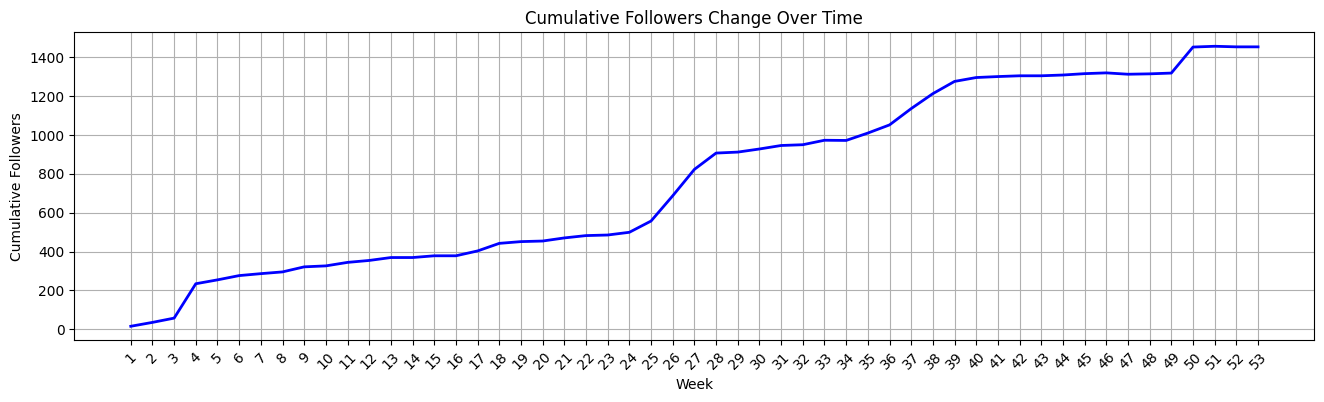

In [55]:
overview['Net follower change'] = overview['New follows'] - overview['Unfollows']

weekly_change = overview.groupby('Week number')['Net follower change'].sum()
weekly_cumulative = weekly_change.cumsum()

plt.figure(figsize=(16, 4))
plt.plot(
    weekly_cumulative.index, 
    weekly_cumulative.values, 
    markersize=8, 
    markerfacecolor='green', 
    markeredgecolor='white', 
    linestyle='-', 
    color='blue', 
    linewidth=2
)

plt.xlabel('Week')
plt.ylabel('Cumulative Followers')
plt.title('Cumulative Followers Change Over Time')
plt.xticks(weekly_cumulative.index, labels=weekly_cumulative.index, rotation=45)
plt.grid(True)
plt.show()

### Weekly Growth Rate

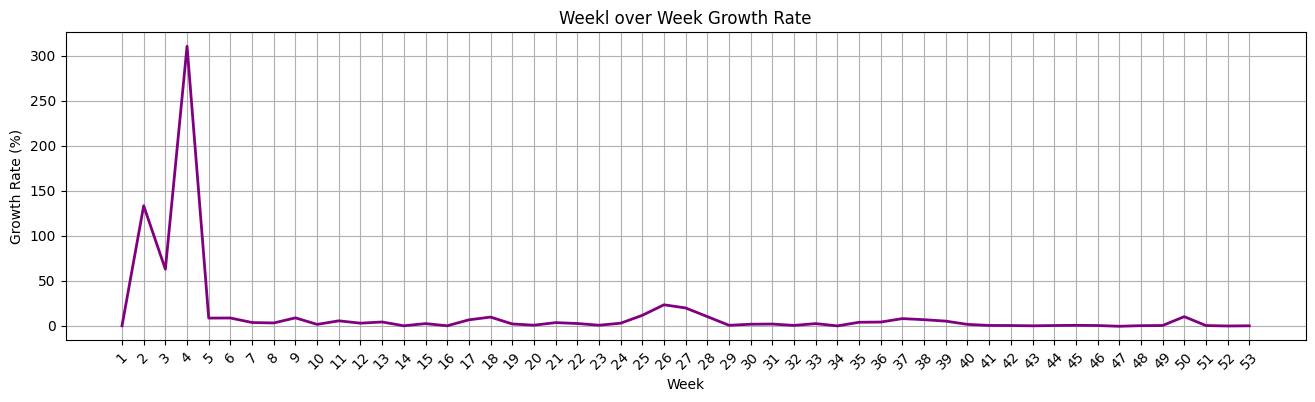

In [56]:
weekly_cumulative_shifted = weekly_cumulative.shift(1)
weekly_growth_rate = (weekly_change / weekly_cumulative_shifted) * 100

# replace NaN or infinite values (first week division by zero) with 0
weekly_growth_rate.fillna(0, inplace=True)
weekly_growth_rate.replace([float('inf'), float('-inf')], 0, inplace=True)

plt.figure(figsize=(16, 4))
plt.plot(
    weekly_growth_rate.index, 
    weekly_growth_rate.values, 
    linestyle='-', 
    color='purple', 
    linewidth=2
)

plt.xlabel('Week')
plt.ylabel('Growth Rate (%)')
plt.title('Weekl over Week Growth Rate')
plt.xticks(weekly_cumulative.index, labels=weekly_cumulative.index, rotation=45)
plt.grid(True)
plt.show()

## Post Data

In [57]:
total_posts = len(posts)
monthly_average = round((total_posts / 3))
print(f'{total_posts} posts over the last 90 days, averaging ~{monthly_average} posts monthly')

250 posts over the last 90 days, averaging ~83 posts monthly


### Top Post Metrics

In [58]:
top_post = posts[posts['Likes'] == posts['Likes'].max()]
most_liked_post_text = top_post['Post text'].iloc[0]
print(f'Most Liked Post:\n\n{most_liked_post_text}\n\n')

top_post_text = top_post['Post text'].iloc[0]

likes = top_post['Likes'].iloc[0]
impressions =  top_post['Impressions'].iloc[0]
engagements =  top_post['Engagements'].iloc[0]
bookmarks =  top_post['Bookmarks'].iloc[0]
shares =  top_post['Share'].iloc[0]

print(f'Likes: {likes}')
print(f'Impressions: {impressions}')
print(f'Engagements: {engagements}')
print(f'Bookmarks: {bookmarks}')
print(f'Shares: {shares}')

Most Liked Post:

decided it’s time to learn app intents. rigged up a simple use case with two intents, and exposed them to the system as a shortcut. code in replies ⬇️ https://t.co/jxXGOPH18r


Likes: 943
Impressions: 89136
Engagements: 2919
Bookmarks: 622
Shares: 20


### Posts by Weekday

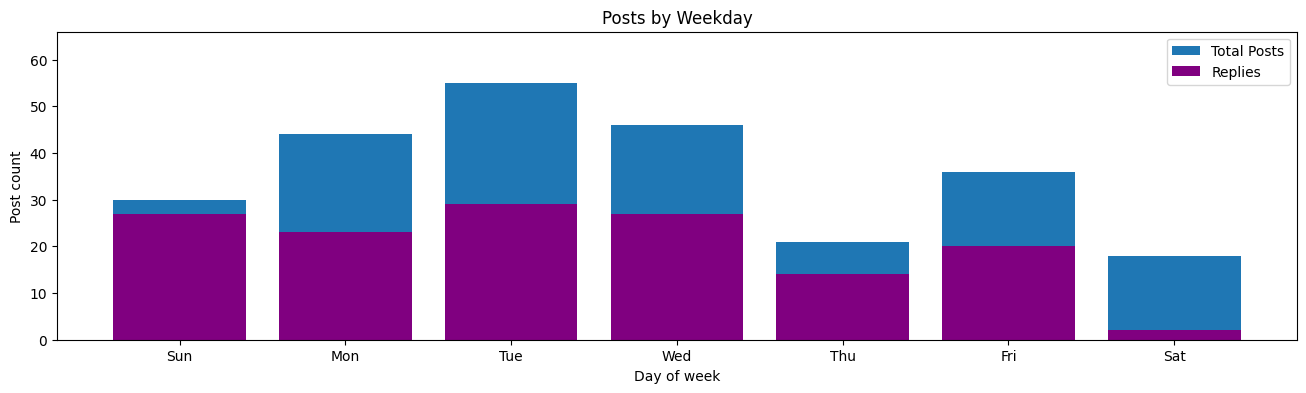

In [59]:
posts_by_weekday = posts.groupby('Weekday', observed=True).size()
replies_by_weekday = posts.groupby('Weekday', observed=True)['Replies'].sum()

plt.figure(figsize=(16,4))
plt.bar(posts_by_weekday.index, posts_by_weekday.values, label='Total Posts')
plt.bar(replies_by_weekday.index, replies_by_weekday.values, color='purple', label='Replies')

plt.xlabel('Day of week')
plt.ylabel('Post count')
plt.title('Posts by Weekday')

plt.ylim(0, (posts_by_weekday.max() * 1.2))  # 20% buffer for headroom

plt.legend()
plt.show()

In [60]:
total_bookmarks = posts['Bookmarks'].sum()

print(f'Users bookmarked your posts {total_bookmarks} times')

Users bookmarked your posts 848 times


In [61]:
total_profile_visits = posts['Profile visits'].sum()

print(f'Your posts brought {total_profile_visits} visits to your profile.')

Your posts brought 720 visits to your profile.


In [62]:
total_likes = posts['Likes'].sum()
avg_likes = total_likes / len(posts)

print(f'Your posts received an average of {avg_likes} likes.')

Your posts received an average of 7.212 likes.


In [63]:
op_posts = posts.copy()
op_posts = op_posts[~op_posts['Post text'].str.startswith('@')]
op_posts['word_count'] = op_posts['Post text'].str.split().str.len()

max = op_posts['word_count'].max()
most_verbose_post = op_posts[op_posts['word_count'] == max]['Post text'].values[0]

print(f'Most verbose post of the last 90 days: \n\n{most_verbose_post}\n')
print(f'Word count: {max}')

Most verbose post of the last 90 days: 

had my first live coding interview today. not as great as i would’ve liked, but not as bad as it could have been. was tasked with building Conway’s Game of Life to simulate cell survival based on the state of neighboring cells. struggled with the 2D array logic checks, and https://t.co/gQfTreqJbw

Word count: 51


### Reply data

In [64]:
replies = posts['Post text'].str.startswith('@').sum()
total_posts = len(posts)
reply_rate = (replies / total_posts * 100).round(2)

print(f'Replies account for {reply_rate}% of all posts')

Replies account for 51.2% of all posts


### Replies by recipient

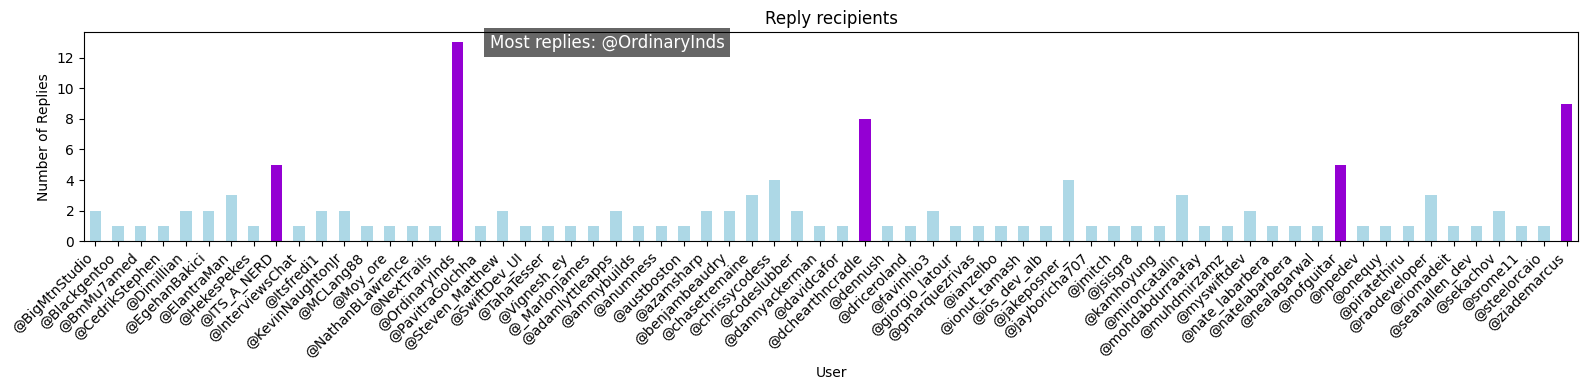

Out of 128 replies, most have been to @OrdinaryInds.


In [75]:
replies_df = posts[posts['Post text'].str.startswith('@')]
grouped_replies = replies_df.groupby(posts['Post text'].str.split().str[0]).size()
most_replied = grouped_replies.idxmax()

plt.figure(figsize=(16, 4))

threshold = 4
colors = ['darkviolet' if count > threshold else 'lightblue' for count in grouped_replies]

grouped_replies.plot(kind='bar', color=colors)

plt.xlabel('User')
plt.ylabel('Number of Replies')
plt.title('Reply recipients')

plt.xticks(rotation=45, ha='right')  
plt.tight_layout()  # Adjust layout for better spacing
plt.text(0.35, 0.95, f"Most replies: {most_replied}", 
         fontsize=12, color="white", ha="center", va="center", 
         bbox=dict(facecolor='black', alpha=0.6, edgecolor='none'), 
         transform=plt.gca().transAxes)
plt.show()

print(f'Out of {len(replies_df)} replies, most have been to {most_replied}.')